# Atelier 3 : Clustering 


L'objectif de cet atelier est de decter le plagiarisme dans une collection de documents texte en regroupant dans les mêmes clusters les documents texte qui etait recopier à partir du même document original. 
On va reprendre le meme dataset des ateliers 1 et 2. 

# 1.	Preparation du DataSet

Ecrire le code permettant de Recuperer le dataset du plagiarisme traité dans les ateliers precedents et appliquer les pretratements necessaires 

In [9]:
import glob
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def get_corpus(url):
    '''Uttiliser la librairie glob pour recuperer les documents dans une 
    liste de listes dont les sous listes representent le contenu des documents 
    du corpus'''
    '''Appliquer la segmentation, le cleaning et la lemmatisation'''
    files=glob.glob(url)
    f_pointers=[open(file,"r",encoding="utf8", errors='ignore') for file in files]
    corpus=[f.read() for f in f_pointers]
    lemmmatizer=WordNetLemmatizer()
    words=[]
    for i in corpus:
        word_tokens = [word.lower() for word in word_tokenize(i)]
        words.append([lemmmatizer.lemmatize(word.lower()) for word in word_tokens if(not word in set(stopwords.words('english')) and  word.isalpha())]) 
    return words

    


In [14]:
corpus=get_corpus('C:/Users/ismail/Desktop/corpus/*')


# 2. Vectorisation 

## 2.1 TF-IDF

Definir le traitement permettant de recuperer la representation vectorielle TFIDF des differents documents du corpus

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorsTFIDF(corpus_lemetized):
    T=[" ".join(c) for c in corpus] #passez de tokens vers docs
    vectorizer = TfidfVectorizer()
    X=vectorizer.fit_transform(T)
    return X.toarray()

In [79]:
res=vectorsTFIDF(corpus)

In [20]:
res #On remarque que la matrice est creuse ceci revient à la immense taille du corpus

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2.2 SVD

Definir le traitement permettant de recuperer la representation vectorielle des differents documents du corpus en se basant sur l'apprche SVD.

In [46]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline



def docVectSVD(corpus_lemetized):
    '''extraire le vocabulaire'''
    Vocabulary=set()
    for c in corpus_lemetized:
        Vocabulary=Vocabulary.union(set(c))
        
    ''' creer la matrice des cooccurrences des termes'''
    n=2 #le nombre de fenetre est 2
    V=len(Vocabulary)
    Vocabulary=sorted(Vocabulary)
    M=np.zeros((V,V))
    for doc in corpus:
        #doc=doc.split(" ")
        T=len(doc)-2*n+1 if n<len(doc) else 1  #le nombre de fenetre dans le document
        for t in range(T):
            m=doc[t:t+2*n+1]
            for i in range(len(m)):
                for j in range(i+1,len(m)):
                    ii=Vocabulary.index(m[i])
                    jj=Vocabulary.index(m[j])
                    M[ii,jj]+=1
                    M[jj,ii]+=1
    
    
    
    ''' Appliquer la reduction SVD'''
    k=2 #le nbre de component du svd est 2 on passera à un vecteur de 2d
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    vectors = lsa.fit_transform(M)
    
    ''' genenrer le dictionaire terme/vecteur'''
    TV=dict()
    for i in range(V):
        TV[Vocabulary[i]]=vectors[i]
    ''' Definir les traitement permettant de recuperer la representation 
        vectorielle des documents du corpus en se basant sur l'apprche SVD 
        (la moyenne des vecteurs composant chaque document).'''
    M=[]# the array that will contain the doc vector
    for doc in corpus:
        v=np.zeros(2)
        for word in doc:
            v+=TV[word]
        v=v/len(doc)
        M.append(v)
    return M
        
            

    
    
    
    
            


In [47]:
A=docVectSVD(corpus)

In [49]:
len(A)

100

In [56]:
A

[array([0.81209861, 0.41558346]),
 array([0.79877308, 0.52155362]),
 array([0.61875715, 0.7481224 ]),
 array([ 0.89659728, -0.17930564]),
 array([0.77420653, 0.57586324]),
 array([0.75173226, 0.63268399]),
 array([0.80081545, 0.49188252]),
 array([0.59775513, 0.76934666]),
 array([ 0.89960745, -0.26179878]),
 array([0.75621729, 0.61376321]),
 array([0.76396313, 0.60931473]),
 array([0.75122598, 0.61428899]),
 array([0.56014052, 0.78825491]),
 array([ 0.91806372, -0.27412151]),
 array([0.74461867, 0.60473476]),
 array([0.75359737, 0.63323761]),
 array([0.748171  , 0.61667438]),
 array([0.64785592, 0.71541423]),
 array([0.93021434, 0.00306355]),
 array([0.75496163, 0.60091177]),
 array([0.76965627, 0.57865266]),
 array([0.7443861 , 0.62965533]),
 array([0.57259033, 0.77467841]),
 array([ 0.89569763, -0.11465252]),
 array([0.75611682, 0.56357714]),
 array([0.74343251, 0.61689259]),
 array([0.76512401, 0.54241061]),
 array([0.61435348, 0.74930279]),
 array([ 0.90847176, -0.17309543]),
 arr

## 2.3 Word2Vec

Definir le traitement permettant de recuperer la representation vectorielle des differents documents du corpus en se basant sur l'apprche word2vec.

tester avec le pretrained glove-wiki-gigaword-50 et avec un apprentissage à partir du corpus.  

In [57]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')


[==================================================] 100.0% 66.0/66.0MB downloaded


In [59]:
len(glove_vectors['data'])

50

In [65]:
def pretrainedDocWV(corpus_lemetized):
    M=[]# the array that will contain the doc vector
    for doc in corpus:
        v=np.zeros(50)
        for word in doc:
            if word in glove_vectors.index_to_key:
                v+=glove_vectors[word]
        v=v/len(doc)
        M.append(v)
    return M

In [73]:
A=pretrainedDocWV(corpus)

In [74]:
len(A)#array that contain the docs vectors

100

In [75]:
A

[array([ 0.17003896,  0.4913341 , -0.0568105 , -0.25952193,  0.20743061,
         0.30348998, -0.0352544 , -0.37771459, -0.02996282, -0.00517019,
         0.21236825,  0.20256225,  0.07195074, -0.03571737, -0.03670881,
         0.02370942, -0.10515498,  0.34057215,  0.08645183, -0.22154099,
         0.15662727, -0.08396614, -0.07951899,  0.21596233, -0.02260392,
        -1.00444633, -0.167752  , -0.38506787, -0.04306401,  0.02153721,
         2.5252169 ,  0.02903256, -0.28669084, -0.51905408,  0.3234538 ,
         0.0834922 ,  0.06241075,  0.25465544,  0.02944727, -0.07951711,
        -0.0176444 , -0.33172086,  0.1197747 ,  0.48153292, -0.20786059,
        -0.17851516,  0.29186666,  0.07256971, -0.01655815,  0.21409674]),
 array([ 0.36739376,  0.17610055,  0.36365104,  0.25975175,  0.25561553,
         0.02776435,  0.01315188, -0.58572388,  0.27871499,  0.15908819,
         0.01844343,  0.12254007, -0.10197344, -0.15521206,  0.07068872,
        -0.02552829, -0.13729153, -0.15203469,  0

In [69]:
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models.word2vec import PathLineSentences
def propreDocWV(corpus_lemetized):
    model = Word2Vec(sentences=corpus_lemetized, vector_size=10, window=3, min_count=1, workers=2)
    M=[]
    for doc in corpus:
        v=np.zeros(10)
        for word in doc:
            v+=model.wv[word]
        v=v/len(doc)
        M.append(v)
    return M

    

In [70]:
A=propreDocWV(corpus)

In [71]:
len(A)

100

In [72]:
A

[array([ 0.15755555, -0.09780812,  0.27132834,  0.05902226,  0.1216593 ,
         0.00318288,  0.27566813,  0.17352637, -0.32269359, -0.24426818]),
 array([ 0.13260683, -0.06858362,  0.24539743,  0.03900449,  0.11479019,
         0.01606354,  0.25285026,  0.15461521, -0.3005637 , -0.20440518]),
 array([ 0.1763037 , -0.07643555,  0.35022504,  0.03221075,  0.17506399,
         0.02147963,  0.33425117,  0.22157126, -0.38508808, -0.28428258]),
 array([ 0.15562793, -0.11082085,  0.27346469,  0.06098704,  0.10035541,
         0.0265021 ,  0.28202286,  0.19476525, -0.30093427, -0.21840222]),
 array([ 0.16396477, -0.08665224,  0.302951  ,  0.03027752,  0.14093686,
         0.02364636,  0.29624204,  0.1877278 , -0.35641563, -0.23861866]),
 array([ 0.11572161, -0.07431938,  0.21646969,  0.03863938,  0.09187579,
         0.01328779,  0.21311283,  0.14127668, -0.25073944, -0.20390569]),
 array([ 0.13231695, -0.0795782 ,  0.256509  ,  0.03306581,  0.12416918,
         0.01105756,  0.24679815,  0.17

## 2.4 Doc2Vec

Definir le traitement permettant de recuperer la representation vectorielle doc2vec des differents documents du corpus

In [50]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
def vectorsDoc2Vec(corpus_lemetized):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lemetized)]
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
    vectors=model.dv.vectors
    return vectors



C:\Users\ismail\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [52]:
B=vectorsDoc2Vec(corpus)

In [76]:
len(B)

100

In [77]:
B

array([[ 0.04595716,  0.17553405,  0.5250935 , -2.2845297 , -0.85599655],
       [ 0.19545783,  0.22010949,  0.5038293 , -2.4059644 , -0.8279007 ],
       [ 0.3378422 ,  0.39106983,  0.42153364, -1.7622682 , -0.74988353],
       [ 0.1301385 ,  0.4731194 ,  0.94793457, -2.6444478 , -1.0911413 ],
       [ 0.09039238,  0.35667014,  0.6680155 , -2.0844069 , -0.6880285 ],
       [ 0.04436799,  0.34125814,  0.8554457 , -3.689006  , -1.7181228 ],
       [ 0.37535995,  0.59773695,  0.58826834, -2.5815609 , -0.987011  ],
       [ 0.4538226 ,  0.42364952,  0.5358182 , -2.4552996 , -0.92345524],
       [ 0.24848202,  0.095089  ,  0.5203259 , -2.0149767 , -0.6377268 ],
       [ 0.02505404,  0.33577543,  0.8347667 , -2.2547603 , -1.0458565 ],
       [ 0.08448569,  0.34983337,  0.59287405, -2.6716821 , -1.0763386 ],
       [ 0.3890215 ,  0.37386584,  0.7730453 , -2.4139216 , -0.6858403 ],
       [ 0.34786776,  0.59146214,  0.8736323 , -2.436857  , -0.8676213 ],
       [ 0.10945639,  0.43246934,  0.5

# 3. Clustering avec K-means 

## 3.1 k-means avec TFIDF

Ci-dessous un exemple d'application du k-means en se basant sur le representation TFIDF.  

In [130]:
#K-MEANS CLUSTERING

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#predict(X[, sample_weight])         : Predict the closest cluster each sample in X belongs to.
#fit_predict(X[, y, sample_weight])  :Compute cluster centers and predict cluster index for each sample.

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#transform(X)                        :Transform X to a cluster-distance space.
#fit_transform(X[, y, sample_weight]):Compute clustering and transform X to cluster-distance space.

#score(X[, y, sample_weight])        : Opposite of the value of X on the K-means objective.


from sklearn.cluster import KMeans

#initialisation automatique
#km = KMeans(n_clusters=5, init='k-means++',n_init=50)


#predetermination des centroids
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=1000)
print("Clustering sparse data with %s" % km)

vect=vectorsTFIDF(get_corpus('C:/Users/ismail/Desktop/corpus/*'))

#reduction
import numpy
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vect = pca.fit_transform(vect)

km.fit(vect)
y_means = km.predict(vect)



Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=1000)


C:\Users\ismail\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=1000.
  self._check_params(X)


Affichage du cluster de chaque document

In [131]:
dict(zip(np.arange(0,100),y_means))

{0: 0,
 1: 2,
 2: 3,
 3: 1,
 4: 0,
 5: 0,
 6: 2,
 7: 3,
 8: 4,
 9: 0,
 10: 0,
 11: 2,
 12: 3,
 13: 4,
 14: 0,
 15: 0,
 16: 2,
 17: 3,
 18: 2,
 19: 0,
 20: 0,
 21: 2,
 22: 3,
 23: 2,
 24: 0,
 25: 0,
 26: 2,
 27: 3,
 28: 1,
 29: 0,
 30: 0,
 31: 2,
 32: 3,
 33: 1,
 34: 0,
 35: 0,
 36: 2,
 37: 3,
 38: 1,
 39: 0,
 40: 0,
 41: 2,
 42: 3,
 43: 1,
 44: 0,
 45: 0,
 46: 2,
 47: 3,
 48: 4,
 49: 0,
 50: 0,
 51: 2,
 52: 3,
 53: 4,
 54: 0,
 55: 0,
 56: 2,
 57: 2,
 58: 1,
 59: 0,
 60: 0,
 61: 2,
 62: 3,
 63: 4,
 64: 0,
 65: 0,
 66: 2,
 67: 3,
 68: 1,
 69: 0,
 70: 0,
 71: 2,
 72: 3,
 73: 4,
 74: 0,
 75: 0,
 76: 2,
 77: 3,
 78: 4,
 79: 0,
 80: 0,
 81: 2,
 82: 2,
 83: 4,
 84: 0,
 85: 0,
 86: 2,
 87: 2,
 88: 1,
 89: 0,
 90: 0,
 91: 2,
 92: 3,
 93: 2,
 94: 0,
 95: 0,
 96: 2,
 97: 3,
 98: 4,
 99: 0}

Le score du modele

In [132]:
#score(X[, y, sample_weight]): Opposite of the value of X on the K-means objective.

km.score(vect)

-0.9829952341824482

Visialisation des clusters 

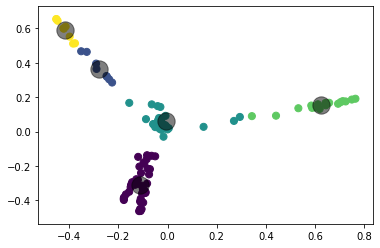

In [133]:
from matplotlib import pyplot as plt
plt.scatter(vect[:,0],vect[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [135]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]


Affichage des clusters

In [136]:

print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[0, 4, 5, 9, 10, 14, 15, 19, 20, 24, 25, 29, 30, 34, 35, 39, 40, 44, 45, 49, 50, 54, 55, 59, 60, 64, 65, 69, 70, 74, 75, 79, 80, 84, 85, 89, 90, 94, 95, 99]
[3, 28, 33, 38, 43, 58, 68, 88]
[1, 6, 11, 16, 18, 21, 23, 26, 31, 36, 41, 46, 51, 56, 57, 61, 66, 71, 76, 81, 82, 86, 87, 91, 93, 96]
[2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 62, 67, 72, 77, 92, 97]
[8, 13, 48, 53, 63, 73, 78, 83, 98]


Classer les documents dans chaque cluster en fonction de leurs similarités avec leur centroid (4 classe:....)
Comparer les resultats obtenus avec les annotation preetablies 

## 3.2 k-means avec SVD

In [150]:
#predetermination des centroids
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)

vect=docVectSVD(get_corpus('C:/Users/ismail/Desktop/corpus/*'))

#reduction
import numpy
from sklearn.decomposition import PCA
#vect = pca.fit_transform(vect)

km.fit(vect)
y_means = km.predict(vect)


Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)


C:\Users\ismail\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  self._check_params(X)


In [151]:
dict(zip(np.arange(0,100),y_means))

{0: 4,
 1: 4,
 2: 0,
 3: 3,
 4: 4,
 5: 4,
 6: 4,
 7: 0,
 8: 3,
 9: 4,
 10: 4,
 11: 4,
 12: 2,
 13: 3,
 14: 4,
 15: 4,
 16: 4,
 17: 1,
 18: 3,
 19: 4,
 20: 4,
 21: 4,
 22: 2,
 23: 3,
 24: 4,
 25: 4,
 26: 4,
 27: 0,
 28: 3,
 29: 4,
 30: 4,
 31: 4,
 32: 0,
 33: 3,
 34: 4,
 35: 4,
 36: 4,
 37: 1,
 38: 3,
 39: 4,
 40: 4,
 41: 4,
 42: 0,
 43: 3,
 44: 4,
 45: 4,
 46: 4,
 47: 0,
 48: 3,
 49: 4,
 50: 4,
 51: 4,
 52: 0,
 53: 3,
 54: 4,
 55: 4,
 56: 4,
 57: 1,
 58: 3,
 59: 4,
 60: 4,
 61: 4,
 62: 0,
 63: 3,
 64: 4,
 65: 4,
 66: 4,
 67: 0,
 68: 3,
 69: 4,
 70: 4,
 71: 4,
 72: 1,
 73: 3,
 74: 4,
 75: 4,
 76: 4,
 77: 1,
 78: 3,
 79: 4,
 80: 4,
 81: 4,
 82: 0,
 83: 3,
 84: 4,
 85: 4,
 86: 4,
 87: 1,
 88: 3,
 89: 4,
 90: 4,
 91: 4,
 92: 2,
 93: 4,
 94: 4,
 95: 4,
 96: 4,
 97: 0,
 98: 3,
 99: 4}

In [152]:
km.score(vect)

-0.6835609181297627

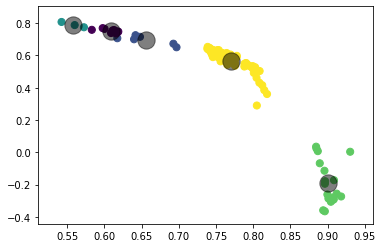

In [153]:
from matplotlib import pyplot as plt
v=np.array(vect)
plt.scatter(v[:,0],v[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [154]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]

print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[2, 7, 27, 32, 42, 47, 52, 62, 67, 82, 97]
[17, 37, 57, 72, 77, 87]
[12, 22, 92]
[3, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 98]
[0, 1, 4, 5, 6, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 25, 26, 29, 30, 31, 34, 35, 36, 39, 40, 41, 44, 45, 46, 49, 50, 51, 54, 55, 56, 59, 60, 61, 64, 65, 66, 69, 70, 71, 74, 75, 76, 79, 80, 81, 84, 85, 86, 89, 90, 91, 93, 94, 95, 96, 99]


## 3.3 k-means avec Word2Vec


## par Pre-trained  glove-wiki-gigaword-50

In [155]:


centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=1000)
print("Clustering sparse data with %s" % km)

vect=pretrainedDocWV(get_corpus('C:/Users/ismail/Desktop/corpus/*'))

#reduction
import numpy
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vect = pca.fit_transform(vect)

km.fit(vect)
y_means = km.predict(vect)








Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=1000)


C:\Users\ismail\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=1000.
  self._check_params(X)


In [156]:
dict(zip(np.arange(0,100),y_means))

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 0,
 5: 0,
 6: 1,
 7: 2,
 8: 4,
 9: 0,
 10: 0,
 11: 1,
 12: 2,
 13: 4,
 14: 0,
 15: 0,
 16: 1,
 17: 2,
 18: 3,
 19: 0,
 20: 0,
 21: 1,
 22: 2,
 23: 4,
 24: 0,
 25: 0,
 26: 1,
 27: 2,
 28: 3,
 29: 0,
 30: 0,
 31: 1,
 32: 2,
 33: 3,
 34: 0,
 35: 0,
 36: 2,
 37: 2,
 38: 3,
 39: 0,
 40: 0,
 41: 1,
 42: 2,
 43: 3,
 44: 0,
 45: 0,
 46: 1,
 47: 2,
 48: 4,
 49: 0,
 50: 0,
 51: 1,
 52: 2,
 53: 4,
 54: 0,
 55: 0,
 56: 1,
 57: 1,
 58: 3,
 59: 0,
 60: 0,
 61: 1,
 62: 2,
 63: 4,
 64: 0,
 65: 0,
 66: 1,
 67: 2,
 68: 3,
 69: 0,
 70: 0,
 71: 1,
 72: 2,
 73: 4,
 74: 0,
 75: 0,
 76: 1,
 77: 2,
 78: 4,
 79: 0,
 80: 0,
 81: 1,
 82: 2,
 83: 4,
 84: 0,
 85: 0,
 86: 2,
 87: 2,
 88: 3,
 89: 0,
 90: 0,
 91: 1,
 92: 3,
 93: 2,
 94: 0,
 95: 0,
 96: 1,
 97: 2,
 98: 4,
 99: 0}

In [157]:
km.score(vect)

-3.0775151021803344

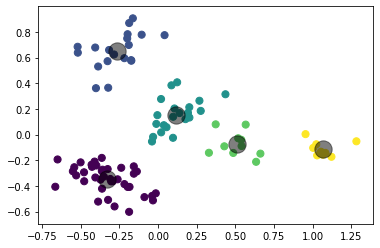

In [158]:
from matplotlib import pyplot as plt
v=np.array(vect)
plt.scatter(v[:,0],v[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [159]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]

print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[0, 4, 5, 9, 10, 14, 15, 19, 20, 24, 25, 29, 30, 34, 35, 39, 40, 44, 45, 49, 50, 54, 55, 59, 60, 64, 65, 69, 70, 74, 75, 79, 80, 84, 85, 89, 90, 94, 95, 99]
[1, 6, 11, 16, 21, 26, 31, 41, 46, 51, 56, 57, 61, 66, 71, 76, 81, 91, 96]
[2, 7, 12, 17, 22, 27, 32, 36, 37, 42, 47, 52, 62, 67, 72, 77, 82, 86, 87, 93, 97]
[3, 18, 28, 33, 38, 43, 58, 68, 88, 92]
[8, 13, 23, 48, 53, 63, 73, 78, 83, 98]


## trained par corpus

In [160]:


centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=1000)
print("Clustering sparse data with %s" % km)

vect=propreDocWV(get_corpus('C:/Users/ismail/Desktop/corpus/*'))

#reduction
import numpy
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vect = pca.fit_transform(vect)

km.fit(vect)
y_means = km.predict(vect)








Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=1000)


C:\Users\ismail\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=1000.
  self._check_params(X)


In [161]:
dict(zip(np.arange(0,100),y_means))

{0: 3,
 1: 4,
 2: 2,
 3: 3,
 4: 3,
 5: 0,
 6: 4,
 7: 2,
 8: 2,
 9: 3,
 10: 3,
 11: 4,
 12: 4,
 13: 2,
 14: 3,
 15: 2,
 16: 0,
 17: 3,
 18: 1,
 19: 1,
 20: 3,
 21: 0,
 22: 2,
 23: 4,
 24: 2,
 25: 2,
 26: 4,
 27: 2,
 28: 3,
 29: 4,
 30: 1,
 31: 4,
 32: 2,
 33: 2,
 34: 3,
 35: 3,
 36: 4,
 37: 2,
 38: 3,
 39: 3,
 40: 0,
 41: 4,
 42: 2,
 43: 2,
 44: 3,
 45: 3,
 46: 4,
 47: 3,
 48: 2,
 49: 2,
 50: 3,
 51: 3,
 52: 2,
 53: 2,
 54: 2,
 55: 3,
 56: 0,
 57: 0,
 58: 3,
 59: 3,
 60: 3,
 61: 3,
 62: 2,
 63: 2,
 64: 4,
 65: 4,
 66: 0,
 67: 2,
 68: 3,
 69: 2,
 70: 2,
 71: 0,
 72: 3,
 73: 2,
 74: 2,
 75: 4,
 76: 0,
 77: 2,
 78: 2,
 79: 2,
 80: 3,
 81: 3,
 82: 4,
 83: 2,
 84: 3,
 85: 4,
 86: 4,
 87: 4,
 88: 0,
 89: 3,
 90: 2,
 91: 4,
 92: 2,
 93: 1,
 94: 0,
 95: 3,
 96: 4,
 97: 2,
 98: 2,
 99: 3}

In [162]:
km.score(vect)

-0.20130117033782266

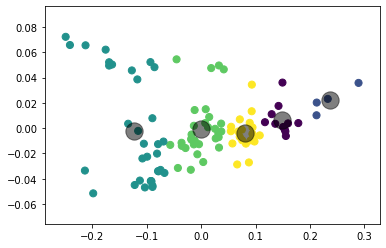

In [163]:
from matplotlib import pyplot as plt
v=np.array(vect)
plt.scatter(v[:,0],v[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [164]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]

print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[5, 16, 21, 40, 56, 57, 66, 71, 76, 88, 94]
[18, 19, 30, 93]
[2, 7, 8, 13, 15, 22, 24, 25, 27, 32, 33, 37, 42, 43, 48, 49, 52, 53, 54, 62, 63, 67, 69, 70, 73, 74, 77, 78, 79, 83, 90, 92, 97, 98]
[0, 3, 4, 9, 10, 14, 17, 20, 28, 34, 35, 38, 39, 44, 45, 47, 50, 51, 55, 58, 59, 60, 61, 68, 72, 80, 81, 84, 89, 95, 99]
[1, 6, 11, 12, 23, 26, 29, 31, 36, 41, 46, 64, 65, 75, 82, 85, 86, 87, 91, 96]


## 3.3 k-means avec Doc2Vec

In [165]:





centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=1000)
print("Clustering sparse data with %s" % km)

vect=vectorsDoc2Vec(get_corpus('C:/Users/ismail/Desktop/corpus/*'))

#reduction
import numpy
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vect = pca.fit_transform(vect)

km.fit(vect)
y_means = km.predict(vect)






Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=1000)


C:\Users\ismail\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=1000.
  self._check_params(X)


In [166]:
dict(zip(np.arange(0,100),y_means))

{0: 0,
 1: 0,
 2: 1,
 3: 2,
 4: 0,
 5: 3,
 6: 2,
 7: 2,
 8: 0,
 9: 0,
 10: 2,
 11: 0,
 12: 2,
 13: 1,
 14: 0,
 15: 0,
 16: 1,
 17: 1,
 18: 4,
 19: 1,
 20: 2,
 21: 1,
 22: 4,
 23: 4,
 24: 4,
 25: 0,
 26: 0,
 27: 0,
 28: 2,
 29: 0,
 30: 2,
 31: 2,
 32: 1,
 33: 0,
 34: 3,
 35: 2,
 36: 3,
 37: 4,
 38: 0,
 39: 0,
 40: 3,
 41: 2,
 42: 0,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 0,
 48: 0,
 49: 2,
 50: 2,
 51: 0,
 52: 0,
 53: 1,
 54: 0,
 55: 3,
 56: 0,
 57: 2,
 58: 0,
 59: 2,
 60: 2,
 61: 0,
 62: 0,
 63: 0,
 64: 3,
 65: 2,
 66: 3,
 67: 0,
 68: 0,
 69: 4,
 70: 1,
 71: 2,
 72: 1,
 73: 4,
 74: 4,
 75: 2,
 76: 3,
 77: 0,
 78: 0,
 79: 2,
 80: 2,
 81: 0,
 82: 0,
 83: 0,
 84: 2,
 85: 2,
 86: 3,
 87: 3,
 88: 3,
 89: 2,
 90: 0,
 91: 0,
 92: 1,
 93: 2,
 94: 2,
 95: 2,
 96: 3,
 97: 1,
 98: 0,
 99: 3}

In [167]:
km.score(vect)

-7.812748432159424

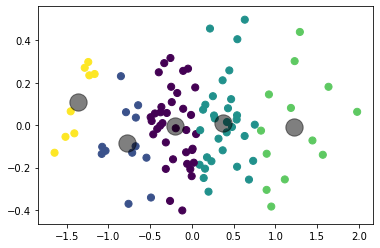

In [168]:
from matplotlib import pyplot as plt
v=np.array(vect)
plt.scatter(v[:,0],v[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [169]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]

print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[0, 1, 4, 8, 9, 11, 14, 15, 25, 26, 27, 29, 33, 38, 39, 42, 47, 48, 51, 52, 54, 56, 58, 61, 62, 63, 67, 68, 77, 78, 81, 82, 83, 90, 91, 98]
[2, 13, 16, 17, 19, 21, 32, 53, 70, 72, 92, 97]
[3, 6, 7, 10, 12, 20, 28, 30, 31, 35, 41, 43, 44, 45, 46, 49, 50, 57, 59, 60, 65, 71, 75, 79, 80, 84, 85, 89, 93, 94, 95]
[5, 34, 36, 40, 55, 64, 66, 76, 86, 87, 88, 96, 99]
[18, 22, 23, 24, 37, 69, 73, 74]
